In [1]:
import os.path as osp
from utils import *
import mmcv
import torch
import wandb
from mmcv import Config
from mmcv.parallel import MMDistributedDataParallel
from mmdet.apis import set_random_seed, train_detector
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from algo2_result_to_aligned_result import algo2_result_to_aligned_result
# Let's take a look at the dataset image
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from xml_to_np import xml_to_np, all_xml_to_np
from AP import calc_iou_individual, get_single_image_results
from soft_nms import py_cpu_softnms
from dbscan_result_to_aligned_result import dbscan_result_to_aligned_result
from AP import calc_iou_individual
import xml.etree.ElementTree as ET
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
from utils import print_LC, detect_quads
import subprocess
import random

/home/quadro/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'cycler'

In [ ]:
checkpoint_file="/media/quadro/NVME/Mehrab/exps/32_quad_long_retry/latest.pth"
config_file='/media/quadro/NVME/Mehrab/Current_Experiment/config.py'

img_path="/media/quadro/NVME/Mehrab/bank_statement.jpg"

In [ ]:
detect_quads(img_path=img_path,
             checkpoint_file=checkpoint_file,
             config_file=config_file)

/media/quadro/NVME/Mehrab/Current_Experiment/mmdet/models/builder.py:51: UserWarning: train_cfg and test_cfg is deprecated, please specify them in model
  warnings.warn(
2024-01-16 14:54:58,616 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.0.conv is upgraded to version 2.
2024-01-16 14:54:58,619 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.2.conv is upgraded to version 2.
2024-01-16 14:54:58,620 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.4.conv is upgraded to version 2.


load checkpoint from local path: /media/quadro/NVME/Mehrab/exps/32_quad_long_retry/latest.pth
torch.Size([1, 3000, 9]) torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = (5400, 5) batch_labels = (3000,)
bbboxes shape  (5400, 5)
labels shape  (3000,)
bbboxes shape  (3000, 5)
labels shape  (3000,)


[array([[738, 499, 816, 499, 821],
        [741, 464, 807, 463, 807],
        [726, 402, 816, 386, 816],
        ...,
        [643, 898, 667, 882, 667],
        [664, 283, 678, 294, 662],
        [ 78, 335, 182, 339, 193]])]

In [ ]:
cfg = Config.fromfile(config_file)

set_random_seed(0, deterministic=False)

dataset = build_dataset(cfg.data.test)

model = build_detector(cfg.model, train_cfg=cfg.model.test_cfg)#, test_cfg=cfg.model.test_cfg)
model.CLASSES = dataset.CLASSES

model = init_detector(config_file, checkpoint_file, device=f'cuda:3')

loading annotations into memory...
Done (t=4.53s)
creating index...
index created!


2024-01-16 14:55:22,046 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.0.conv is upgraded to version 2.
2024-01-16 14:55:22,049 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.2.conv is upgraded to version 2.
2024-01-16 14:55:22,051 - root - INFO - ModulatedDeformConvPack neck.deconv_layers.4.conv is upgraded to version 2.


load checkpoint from local path: /media/quadro/NVME/Mehrab/exps/32_quad_long_retry/latest.pth


In [ ]:
conf_threshold = 0.5
iou_threshold = 0.9
res = []
# for idx in tqdm(range(int(len(dataset)))):
idx = 7
anno = dataset.get_ann_info(idx=idx)
boxes = anno["bboxes"]
segm_path = anno["seg_map"]
# xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/{segm_path[:-4]}.xml"
# img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/{segm_path[:-4]}.jpg"
img_path = f"/media/quadro/NVME/Mehrab/datasets/test/images/11e8c54bfc1c398f048045b61d12db94.jpg"
xml_path = f"/media/quadro/NVME/Mehrab/datasets/test/xml/11e8c54bfc1c398f048045b61d12db94.xml"
# img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/1vzhDVZkRiOr9FWYuJP7oQAAACMAAQED.jpg"
# xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/1vzhDVZkRiOr9FWYuJP7oQAAACMAAQED.xml"
# img_path = f"/home/aiarhipov/datasets/WTW-dataset/test/images/mit_google_image_search-10918758-86d8fb6ae7082304fd621df58c68adee00278d96.jpg"
# xml_path = f"/home/aiarhipov/datasets/WTW-dataset/test/xml/mit_google_image_search-10918758-86d8fb6ae7082304fd621df58c68adee00278d96.xml"


print(img_path)
gt_boxes = xml_to_np(xml_path)
# print(f"gt_boxes[0] = {gt_boxes[:5]}")
pred = inference_detector(model, img_path)
# print(pred.shape)
# pred = pred[int(len(pred)/2):]
# print(f"pred[0] = {pred[:5]}")
# conf_indexes = py_cpu_softnms(pred[:, :4], pred[:, 4], thresh=0.475, method=2)
# print(f"conf_indexes = {conf_indexes}")
# conf_pred = pred[conf_indexes]
# print(f"conf_pred[0] = {conf_pred[:5]}")
# if conf_pred.shape[0] > 1:
#     conf_pred = dbscan_result_to_aligned_result([conf_pred])
#     if conf_pred:
#         conf_pred = conf_pred[0]
#         print(gt_boxes[:, :4].shape)
#         print(conf_pred[:, :4].shape)

/media/quadro/NVME/Mehrab/datasets/test/images/11e8c54bfc1c398f048045b61d12db94.jpg
torch.Size([1, 3000, 9]) torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = (5400, 5) batch_labels = (3000,)
bbboxes shape  (5400, 5)
labels shape  (3000,)
bbboxes shape  (3000, 5)
labels shape  (3000,)


In [ ]:
import warnings
from pathlib import Path

import mmcv
import numpy as np
import torch
from mmcv.ops import RoIPool
from mmcv.parallel import collate, scatter
from mmcv.runner import load_checkpoint

from mmdet.core import get_classes
from mmdet.datasets import replace_ImageToTensor
from mmdet.datasets.pipelines import Compose
from mmdet.models import build_detector
imgs = img_path
if isinstance(imgs, (list, tuple)):
    is_batch = True
else:
    imgs = [imgs]
    is_batch = False

cfg = model.cfg
device = next(model.parameters()).device  # model device

if isinstance(imgs[0], np.ndarray):
    cfg = cfg.copy()
    # set loading pipeline type
    cfg.data.test.pipeline[0].type = 'LoadImageFromWebcam'

cfg.data.test.pipeline = replace_ImageToTensor(cfg.data.test.pipeline)
test_pipeline = Compose(cfg.data.test.pipeline)

datas = []
for img in imgs:
    # prepare data
    if isinstance(img, np.ndarray):
        # directly add img
        data = dict(img=img)
    else:
        # add information into dict
        data = dict(img_info=dict(filename=img), img_prefix=None)
    # build the data pipeline
    data = test_pipeline(data)
    datas.append(data)

data = collate(datas, samples_per_gpu=len(imgs))
# just get the actual data from DataContainer
data['img_metas'] = [img_metas.data[0] for img_metas in data['img_metas']]
data['img'] = [img.data[0] for img in data['img']]
if next(model.parameters()).is_cuda:
    # scatter to specified GPU
    data = scatter(data, [device])[0]
else:
    for m in model.modules():
        assert not isinstance(
            m, RoIPool
        ), 'CPU inference with RoIPool is not supported currently.'

# forward the model
with torch.no_grad():
    results = model(return_loss=False, rescale=True, **data)

# model.forward(data['img'], data['img_metas'], return_loss=False)
center_heatmap_preds, offset_preds, center2vertex_pred, vertex2center_pred = model.bbox_head(model.extract_feat(data['img'][0]))
# gb = model.bbox_head.get_bboxes(center_heatmap_preds, offset_preds, center2vertex_pred, vertex2center_pred, data['img_metas'][0])
result_list = []
for img_id in range(len(data['img_metas'])):
    result_list.append(
        model.bbox_head._get_bboxes_single(
            center_heatmap_preds[0][img_id : img_id + 1, 0:1, ...],
            center2vertex_pred[0][img_id : img_id + 1, ...],
            offset_preds[0][img_id : img_id + 1, ...],
            data['img_metas'][img_id][0],
            rescale=False,
            with_nms=False,
        )
    )
print(result_list[0][0].reshape(result_list[0][1].shape[0], -1).shape, result_list[0][1].shape)

torch.Size([1, 3000, 9]) torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = (5400, 5) batch_labels = (3000,)
bbboxes shape  (5400, 5)
labels shape  (3000,)
bbboxes shape  (3000, 5)
labels shape  (3000,)
torch.Size([1, 3000, 9]) torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 3000, 9]), batch_labels = torch.Size([1, 3000])
before in _get_bboxes_single batch_det_bboxes = torch.Size([1, 30

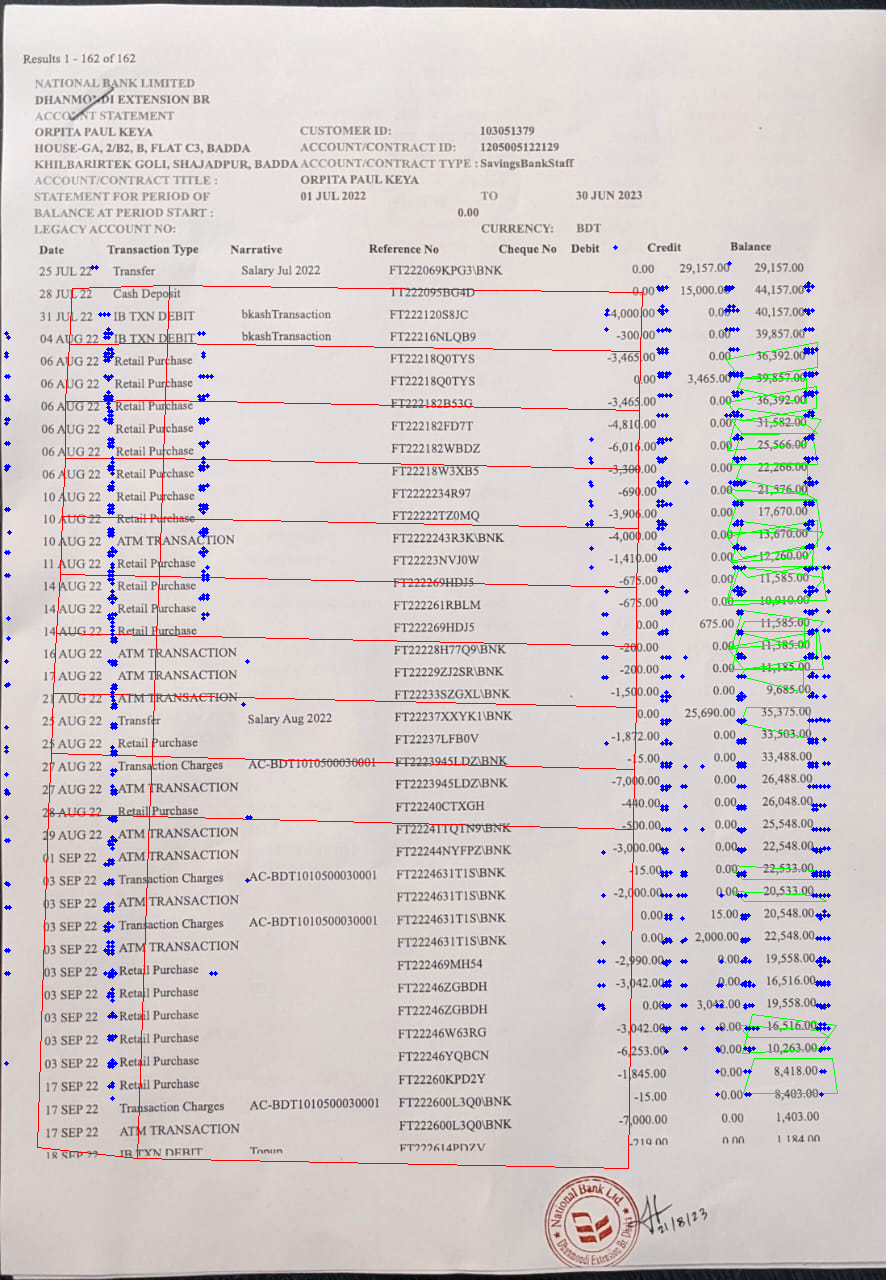

In [ ]:
quads = result_list[0][0].reshape(result_list[0][1].shape[0], -1)[:25]
import cv2
import numpy as np
from PIL import Image
from mmdet.models.utils.gaussian_target import get_local_maximum, get_topk_from_heatmap, transpose_and_gather_feat

# im = Image.open("/home/aiarhipov/centernet/imgs/tmp.jpg")
img = cv2.imread(img_path)
quads = quads.cpu().detach().numpy().astype(int)
for quad in quads:
    cv2.line(img, (quad[0], quad[1]), (quad[2], quad[3]), (0, 255, 0), thickness=1)
    cv2.line(img, (quad[2], quad[3]), (quad[4], quad[5]), (0, 255, 0), thickness=1)
    cv2.line(img, (quad[4], quad[5]), (quad[6], quad[7]), (0, 255, 0), thickness=1)
    cv2.line(img, (quad[6], quad[7]), (quad[0], quad[1]), (0, 255, 0), thickness=1)
    
gt_boxes = all_xml_to_np(xml_path)
gt_boxes = gt_boxes.astype(int)
for quad in gt_boxes:
    cv2.line(img, (quad[0], quad[1]), (quad[2], quad[3]), (255, 0, 0), thickness=1)
    cv2.line(img, (quad[2], quad[3]), (quad[4], quad[5]), (255, 0, 0), thickness=1)
    cv2.line(img, (quad[4], quad[5]), (quad[6], quad[7]), (255, 0, 0), thickness=1)
    cv2.line(img, (quad[6], quad[7]), (quad[0], quad[1]), (255, 0, 0), thickness=1)
    

height, width = center_heatmap_preds[0].shape[2:]
inp_h, inp_w = img.shape[:2]

center_heatmap_pred = get_local_maximum(center_heatmap_preds[0][:, 1:2, ...], kernel=1)

*batch_dets, topk_ys, topk_xs = get_topk_from_heatmap(center_heatmap_pred, k=1000)
batch_scores, batch_index, batch_topk_labels = batch_dets
offset = transpose_and_gather_feat(offset_preds[0], batch_index)
# print(topk_xs, topk_ys)

topk_xs = topk_xs + offset[..., 0]
topk_ys = topk_ys + offset[..., 1]
# print(topk_xs, topk_ys)
for x, y in zip(topk_xs[0].cpu().detach().numpy(), topk_ys[0].cpu().detach().numpy()):
    cv2.circle(img, (int(x * (inp_w / width)), int(y * (inp_h / height))), radius=2, color=(0, 0, 255), thickness=-1)
Image.fromarray(img)

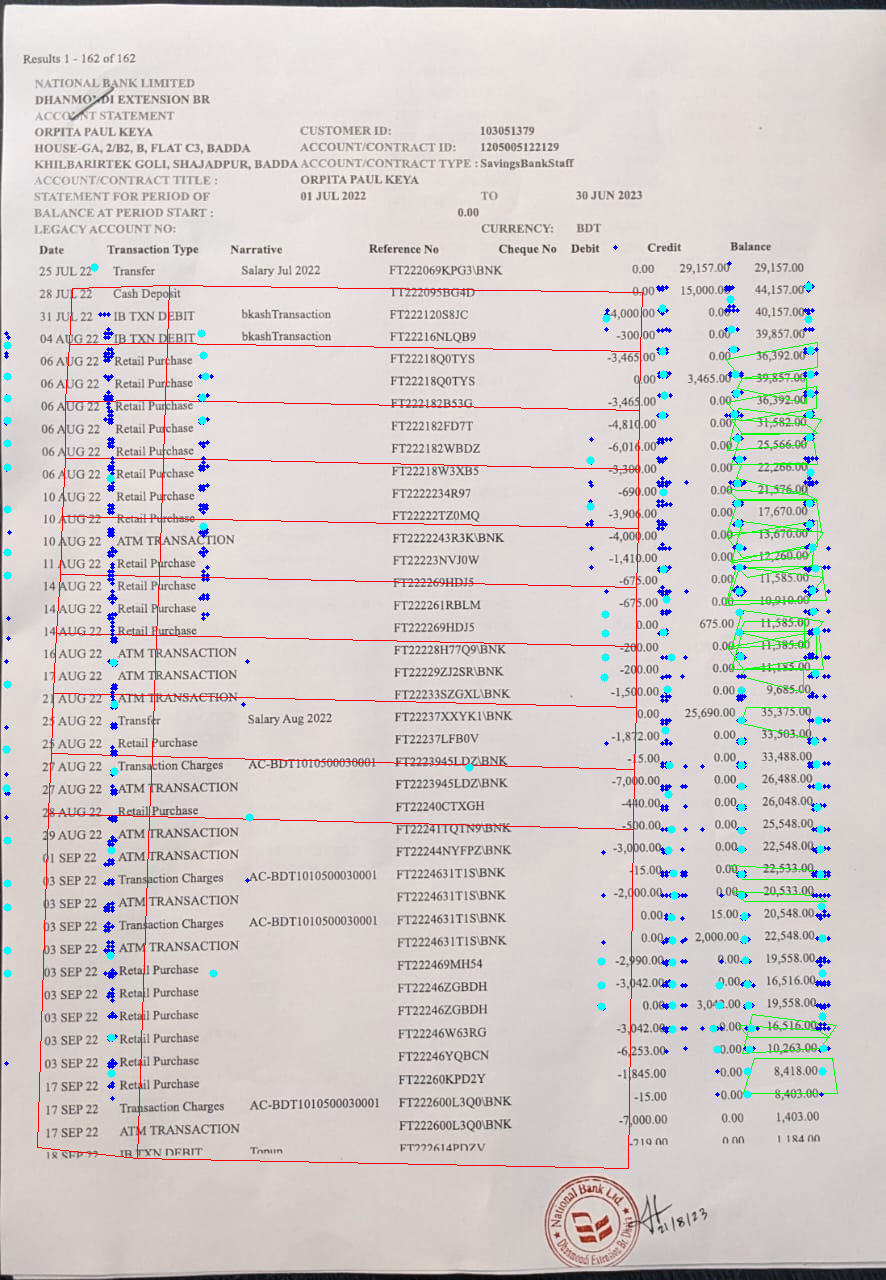

In [ ]:
from sklearn.cluster import dbscan
from sklearn.preprocessing import MinMaxScaler
vertexes = np.vstack([topk_xs[0].cpu().detach().numpy(), topk_ys[0].cpu().detach().numpy()]).T
scaler = MinMaxScaler()
clusters = dbscan(scaler.fit_transform(vertexes), eps=0.02, min_samples=2)
index, labels = clusters
for label in np.unique(labels):
    x, y = vertexes[labels == label].mean(axis=0)
    cv2.circle(img, (int(x * (inp_w / width)), int(y * (inp_h / height))), radius=4, color=(0, 255, 255), thickness=-1)
Image.fromarray(img)